In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent); os.chdir(set_path)

In [2]:
import torch
import matplotlib.pyplot as plt
from FittedModels.utils import plot_distributions
torch.manual_seed(5)
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from TargetDistributions.BayesianNN import PosteriorBNN
from FittedModels.Models.FlowModel import FlowModel
from FittedModels.utils import plot_distributions
from FittedModels.train import LearntDistributionManager
from Utils import plot_func2D, MC_estimate_true_expectation

### Expectation Function

In [3]:
def expectation_function(x):
    A = torch.ones((x.shape[-1], x.shape[-1]))
    return torch.einsum("bi,ij,bj->b", x, A, x)

# Specifiy target distribution and key param

In [4]:
epochs = 50
n_samples_estimation = int(1e4)
target = PosteriorBNN(n_datapoints=10, x_dim=2, y_dim=2, n_hidden_layers=2, layer_width=5)
dim = target.n_parameters

# DReG
Let's instantiate a flow based model, and train using DReG

In [6]:
learnt_sampler = FlowModel(x_dim=dim)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG")
expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

In [7]:
history = tester.train(epochs, batch_size=100)
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size is {info['effective_sample_size']} \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

loss: -403.1826477050781:  50%|████████████████████████████████████████████████████████████                                                            | 25/50 [00:09<00:09,  2.63it/s]


Exception: NaN loss encountered

In [8]:
plt.violinplot([info['normalised_sampling_weights']])
plt.yscale("log")

NameError: name 'info' is not defined

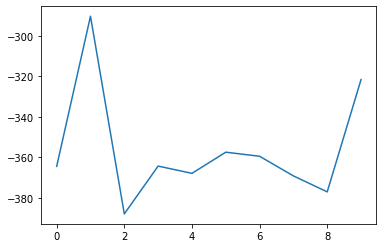

In [17]:
plt.plot(history["loss"])

# KL

In [18]:
learnt_sampler = FlowModel(x_dim=dim)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="kl")
expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

In [19]:
history = tester.train(epochs)
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size is {info['effective_sample_size']} \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

loss: 374.9189758300781: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.28s/it]


estimate before training is 9.838452339172363 
estimate after training is 17.517335891723633 
effective sample size is 4.589569568634033 
variance in weights is 2.178071008529514e-05


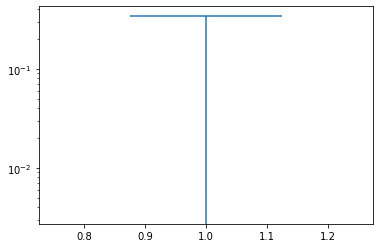

In [20]:
plt.violinplot([info['normalised_sampling_weights']])
plt.yscale("log")

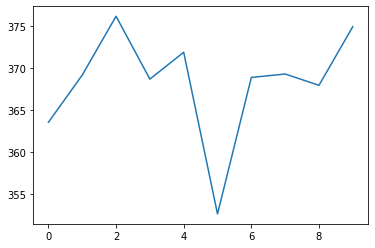

In [21]:
plt.plot(history["loss"])